In [ ]:
!pip install networkx
# !pip install pydot
# !pip install openpyxl
# !pip install pandas
# !pip install anytree
# !pip install graphviz

In [1]:
import pandas as pd
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import matplotlib.pyplot as plt
import networkx as nx
import re
import numpy as np

# importing the data

In [30]:
data = pd.read_excel("data/PBS/May/ETL_PIMData4AIModel_Artikelbeschreibung_20230507.xlsx")
attr_data_may1 = pd.read_excel("data/PBS/May/ETL_PIMData4AIModel_Artikelattribute_20230507_1.xlsx")
attr_data_may2 = pd.read_excel("data/PBS/May/ETL_PIMData4AIModel_Artikelattribute_20230507_2.xlsx")
attr_data_may3 = pd.read_excel("data/PBS/May/ETL_PIMData4AIModel_Artikelattribute_20230507_3.xlsx")

eclass_namen = pd.read_excel("data/PBS/eClass8.1_Namen.xlsx")

# importing the dumps with variance in their products (products were removed or added)
# data_6 = pd.read_excel("data/PBS/2023-05-31/ETL_PIMData4AIModel_Artikelbeschreibung_20230507.xlsx")
# data_7 = pd.read_excel("data/PBS/2023-06-06/ETL_PIMData4AIModel_Artikelbeschreibung_20230525.xlsx")
# data_8 = pd.read_excel("data/PBS/2023-07-17/ETL_PIMData4AIModel_Artikelbeschreibung_20230525.xlsx")
# data_9 = pd.read_excel("data/PBS/2023-08-16/ETL_PIMData4AIModel_Artikelbeschreibung_2023-08-16.xlsx")


In [3]:
features_df = pd.concat([attr_data_may1, attr_data_may2, attr_data_may3])
del attr_data_may1, attr_data_may2, attr_data_may3 

In [4]:
def sort_the_data(data):
    df = pd.DataFrame(data[['Konzernartikelnummer', 'ECLASS_8_1']])
    sorted_df = df.sort_values('ECLASS_8_1')
    sorted_df.reset_index(inplace=True)
    sorted_df.drop(columns=['index'], inplace=True)
    
    return sorted_df

sorted_df = sort_the_data(data)
sorted_df

,Konzernartikelnummer,ECLASS_8_1
0,3000034216,14029090
1,3000541045,14029090
2,3000072878,14029090
3,3000482177,14029090
4,1000391083,14029090
...,...,...
231625,1000539148,42021690
231626,3000536359,42021690
231627,1000387278,90909090
231628,1000427664,90909090


# preprocessing the data

In [5]:
# split the dataset into 
# groupby products, get their counts. 

def preprocess_data(data):
    sorted_df = sort_the_data(data)
    copied_sorted_df = sorted_df.copy()

    copied_sorted_df['class_count'] = 1
    copied_sorted_df['ECLASS_8_1'] = copied_sorted_df['ECLASS_8_1'].map(str)
    print(type(copied_sorted_df['ECLASS_8_1'][0]))

    # aggregates the rows and sums the product class numbers to extract their count}
    summed_leaves = copied_sorted_df.groupby(by='ECLASS_8_1').agg(sum)
    summed_leaves.reset_index(inplace=True)

    # extracts and splits the ECLASS_8_1 values, into the first two, first 4, first 6, and first 8 (all) digits. "i" is the layer (first i) numbers
    # applies the function on all the rows of the dataset
    for i in range(1,5): 
        layername = "layer_"+str(i)
        summed_leaves[layername] = summed_leaves['ECLASS_8_1'].apply(func=lambda x, i: x[0: i*2]+"0"* (4-i) * 2, args=(i,))
        summed_leaves[layername] = summed_leaves[layername].astype('int64')

    return summed_leaves   


summed_leaves = preprocess_data(data)

# zero_layer to act as the root node 
summed_leaves['layer_0'] = 0

summed_leaves

<class 'str'>


/tmp/ipykernel_126/1930461088.py:13: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  summed_leaves = copied_sorted_df.groupby(by='ECLASS_8_1').agg(sum)


,ECLASS_8_1,Konzernartikelnummer,class_count,layer_1,layer_2,layer_3,layer_4,layer_0
0,14029090,35002944688,13,14000000,14020000,14029000,14029090,0
1,14030301,2000641928,2,14000000,14030000,14030300,14030301,0
2,14081402,8002936717,6,14000000,14080000,14081400,14081402,0
3,14081490,5002333746,5,14000000,14080000,14081400,14081490,0
4,15030301,2000801735,2,15000000,15030000,15030300,15030301,0
...,...,...,...,...,...,...,...,...
2340,41120214,10002529411,10,41000000,41120000,41120200,41120214,0
2341,41120306,2001100158,2,41000000,41120000,41120300,41120306,0
2342,41120308,84013536336,30,41000000,41120000,41120300,41120308,0
2343,42021690,12402709654,6,42000000,42020000,42021600,42021690,0


In [ ]:
# summed_leaves.to_csv('calculated_files/layered_descriptions.csv', index=False)

In [6]:
'''Removing the classes with class counts of lower than 10. 1166 rows, grouped by the removed. 
This dataset will later be used for clustering and is irrelevant to the rest of this notebook.
'''
summed_leaves['ECLASS_8_1'] = summed_leaves['ECLASS_8_1'].astype('int')
below_threshold_indices = summed_leaves.loc[summed_leaves.class_count<10].ECLASS_8_1
kan_data = data[data.ECLASS_8_1.isin(list(below_threshold_indices))].Konzernartikelnummer # for features

data = data[~data.ECLASS_8_1.isin(list(below_threshold_indices))]
# save
# data.to_csv("calculated_files/descriptions_frequent_product_groups_above9.csv", index=False)

features_df = features_df[~features_df.Konzernartikelnummer.isin(list(kan_data))]
features_df.shape # before: 1998588, after removal: 1973873 
# features_df.to_csv("calculated_files/subcat_features_frequent_product_groups_above9.csv", index=False)

(1973873, 4)

In [ ]:
data.shape # 231630, 227910

(227910, 10)

In [7]:
'''Merging the layers across the whole descriptions dataset'''
sorted_df
summed_leaves2 = summed_leaves.loc[summed_leaves.class_count>9]
summed_leaves2 = summed_leaves2.drop(['layer_0', 'Konzernartikelnummer'], axis=1)
descr_data_layered = pd.merge(data, summed_leaves2, on='ECLASS_8_1', how='left') # same number of rows as the data
# descr_data_layered.to_csv("calculated_files/subcat_descr.csv", index=False)

descr_layered_copy = descr_data_layered[['Konzernartikelnummer', 'layer_1', 'layer_2', 'layer_3', 'layer_4']].copy()
features_data_layered = pd.merge(features_df, descr_layered_copy, on='Konzernartikelnummer', how='left') # same number of rows as the data

# features_data_layered.to_csv("calculated_files/subcat_features.csv", index=False)

# product_descriptions_subcategorized_count_above9

In [8]:
descr_layered_copy = descr_data_layered[['Konzernartikelnummer', 'layer_1', 'layer_2', 'layer_3', 'layer_4']].copy()
descr_layered_copy

,Konzernartikelnummer,layer_1,layer_2,layer_3,layer_4
0,2766168000,24000000,24290000,24292400,24292401
1,1000255650,24000000,24360000,24360200,24360202
2,1000228410,19000000,19140000,19140600,19140605
3,2015997000,24000000,24260000,24261300,24261301
4,1000167800,24000000,24290000,24292200,24292201
...,...,...,...,...,...
227905,5300004519,24000000,24300000,24301600,24301609
227906,5300015645,24000000,24260000,24260300,24260304
227907,5300014059,24000000,24310000,24310700,24310711
227908,5400010173,24000000,24290000,24291300,24291301


### Number of groups for each layer

In [ ]:
print("layer 1 has " + str(len(descr_layered_copy['layer_1'].unique()))+ " number of groups")
print("layer 2 has " + str(len(descr_layered_copy['layer_2'].unique()))+ " number of groups")
print("layer 3 has " + str(len(descr_layered_copy['layer_3'].unique()))+ " number of groups")
print("layer 4 has " + str(len(descr_layered_copy['layer_4'].unique()))+ " number of groups")

layer 1 has 19 number of groups
layer 2 has 124 number of groups
layer 3 has 439 number of groups
layer 4 has 1179 number of groups


In [9]:
KAN_descriptions = set(descr_layered_copy.Konzernartikelnummer)
KAN_features = set(features_df.Konzernartikelnummer)

print(f"Number of KANs in descriptions and not in features: {len(KAN_descriptions.difference(KAN_features))}")
print(f"Number of KANs in features and not in descriptions: {len(KAN_features.difference(KAN_descriptions))}")
print("These are the numbers after removing products in categories of size less than 10.\
    The products not available in the descriptions' dataset, do not have their categories defined.\
    Therefore, we have nulls for the in the features dataset layers.")

features_data_layered.layer_1.isnull().sum()

Number of KANs in descriptions and not in features: 28125
Number of KANs in features and not in descriptions: 12275
These are the numbers after removing products in categories of size less than 10.    The products not available in the descriptions' dataset, do not have their categories defined.    Therefore, we have nulls for the in the features dataset layers.


41690

## Data analysis
Description and visualization


In [9]:
#analyze the data

summed_leaves.describe()

,ECLASS_8_1,Konzernartikelnummer,class_count,layer_1,layer_2,layer_3,layer_4,layer_0
count,2.345000e+03,2.345000e+03,2345.000000,2.345000e+03,2.345000e+03,2.345000e+03,2.345000e+03,2345.0
mean,2.595927e+07,2.210582e+11,98.776119,2.574371e+07,2.595704e+07,2.595924e+07,2.595927e+07,0.0
std,5.990557e+06,8.969680e+11,462.367996,6.033502e+06,5.990878e+06,5.990558e+06,5.990557e+06,0.0
min,1.402909e+07,1.000014e+09,1.000000,1.400000e+07,1.402000e+07,1.402900e+07,1.402909e+07,0.0
25%,2.422011e+07,5.400011e+09,2.000000,2.400000e+07,2.422000e+07,2.422010e+07,2.422011e+07,0.0
50%,2.429922e+07,2.128442e+10,10.000000,2.400000e+07,2.429000e+07,2.429920e+07,2.429922e+07,0.0
75%,2.711033e+07,1.126426e+11,44.000000,2.700000e+07,2.711000e+07,2.711030e+07,2.711033e+07,0.0
max,9.090909e+07,2.514116e+13,11540.000000,9.000000e+07,9.090000e+07,9.090900e+07,9.090909e+07,0.0


In [ ]:
summed_leaves.loc[summed_leaves['class_count']==11379.000000]

,ECLASS_8_1,ECLASS_Name,Text,class_count,layer_1,layer_2,layer_3,layer_4,layer_0
1524,24340307,"Glückwunschkarte, Trauerkarte (bedruckt)Glückw...",Einladungskarte Kinder 8ST 49041Geburtstagbill...,11379,24,2434,243403,24340307,0


In [ ]:
''' EClass and Konzernartikelnummer do not have a one-on-one correlation.'''

# corr = data['ECLASS_8_1'].corr(data['Konzernartikelnummer'])
# print(corr)

0.018751605413689632


### visualization
first with the long tail of 1's, then without

In [12]:
summed_leaves_frequency = summed_leaves[['class_count', 'ECLASS_8_1']]

summed_leaves_frequency.set_index('ECLASS_8_1')

,class_count
ECLASS_8_1,
14029090,13
14030301,2
14081402,6
14081490,5
15030301,2
...,...
41120214,10
41120306,2
41120308,30


In [14]:
data_sorted

,class_count,ECLASS_8_1
1898,1,29110208
1708,1,25250390
316,1,21043711
315,1,21043706
314,1,21043705
...,...,...
1642,4918,24349090
1570,5347,24340202
1873,6658,29100304
129,9658,19140601


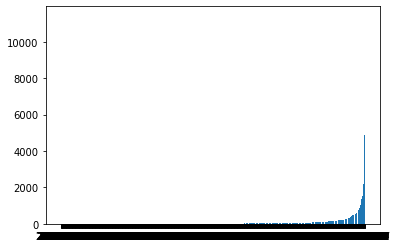

In [ ]:
import seaborn as sns

summed_leaves_frequency = summed_leaves[['class_count', 'ECLASS_8_1']]

summed_leaves_frequency.set_index('ECLASS_8_1')
# summed_leaves_frequency
plt.figure()
# summed_leaves_frequency.value_counts().plot(kind='bar')
data_sorted = summed_leaves_frequency.sort_values('class_count')
data_sorted
plt.bar(data_sorted.ECLASS_8_1, data_sorted.class_count)
plt.show()


# class_count -> frequency 

C:\Users\zpakz\AppData\Local\Temp\ipykernel_14856\283668597.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  bar_fig.show()


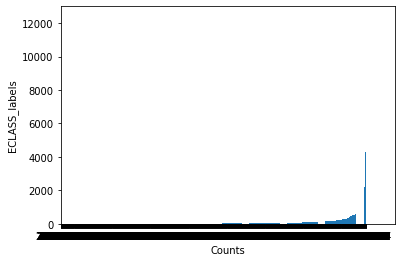

In [ ]:
# removing (cutting) the long tail of 1's from the data
cut_data_sorted = data_sorted.drop(data_sorted.loc[data_sorted['class_count'] == 1].index,  axis=0, inplace=False) 

# data
bar_fig = plt.figure()
plt.bar(cut_data_sorted.ECLASS_8_1, cut_data_sorted.class_count)
plt.ylim([0, 13000])
plt.xlim([0, 2000])
plt.ylabel('ECLASS_labels')
plt.xlabel('Counts')
# bar_fig.show()
bar_fig.savefig("bar_cut.pdf", format="pdf")
bar_fig.show()

# Drawing the graph

In [23]:
# remove the products with a count lower than the specified threshold

# todo: find the correlation between this threshold and the one for colors/size

threshold = 40
copy_summed_leaves = summed_leaves.copy()
# copy_summed_leaves = data.copy()

copy_summed_leaves.drop(copy_summed_leaves.loc[copy_summed_leaves['class_count']<threshold].index, axis=0, inplace=True)

In [ ]:
summed_leaves.shape

(2345, 10)

In [24]:
# get the counts of each layer, creates a separate dataset between each layer with the counts of the destination layer

# # layer 1 and its counts, example. The generic function is defined below
# layer_1_count = summed_leaves.groupby(by='layer_1').agg(sum)
# layer_1_count.reset_index(inplace=True)
# layer1 = layer_1_count[['layer_1','layer_1_count']]


def aggregate_df_by_sum(df, layer_num):
    layer = 'layer_' + str(layer_num)
    layer_ = 'layer_' 
    count_col = layer + 'count' 
    
    # df[count_col] = 1
    # df = summed_leaves.groupby(by=layer).agg(sum)
    # df.reset_index(inplace=True)
    # result_df = df[[layer,count_col]]

    lay_temp = df[['layer_'+str(layer_num), 'layer_'+str(layer_num+1)]]
    lay_temp['count'] = 1
    lay_temp = lay_temp.groupby(by=['layer_'+str(layer_num), 'layer_'+str(layer_num+1)]).agg(sum)
    lay_temp.reset_index(inplace=True)
    result_df = lay_temp

    return result_df

layer0_df = aggregate_df_by_sum(copy_summed_leaves, 0)
layer1_df = aggregate_df_by_sum(copy_summed_leaves, 1)
layer2_df = aggregate_df_by_sum(copy_summed_leaves, 2)
layer3_df = aggregate_df_by_sum(copy_summed_leaves, 3)
# layer4_df = aggregate_df_by_sum(summed_leaves, 4)
layer3_df


/tmp/ipykernel_126/2066183523.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lay_temp['count'] = 1
/tmp/ipykernel_126/2066183523.py:21: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  lay_temp = lay_temp.groupby(by=['layer_'+str(layer_num), 'layer_'+str(layer_num+1)]).agg(sum)
/tmp/ipykernel_126/2066183523.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,layer_3,layer_4,count
0,16030200,16030290,1
1,16070200,16070290,1
2,16100200,16100290,1
3,16110100,16110190,1
4,16120100,16120190,1
...,...,...,...
614,41010500,41010510,1
615,41070300,41070304,1
616,41090200,41090290,1
617,41090500,41090501,1


In [ ]:
summed_leaves


,ECLASS_8_1,ECLASS_Name,Text,class_count,layer_1,layer_2,layer_3,layer_4,layer_0
0,14029090,"Transport (Sonstige, nicht spezifiziert)Transp...","aus dem Jahr 2005, Lieferant 8888,CP 1001-02 V...",3,14,1402,140290,14029090,0
1,14030301,"Reinigung durch Desinfektion, Einwegverkehr (L...",Handdesinfektionsschaum 47 ml DEP 2078648 Hyp...,2,14,1403,140303,14030301,0
2,14070604,Verpackung (Logistik),Verpackung,1,14,1407,140706,14070604,0
3,14081402,"Transport Brief, PostkarteTransport Brief, Pos...",Allgemeine Karte ohne Text sort. 75-454 im Dis...,6,14,1408,140814,14081402,0
4,14081490,"Transport Postsendung, Paketsendung (nicht spe...",Transportwagen +1Klappbox 780011 CLAX 981793...,5,14,1408,140814,14081490,0
...,...,...,...,...,...,...,...,...,...
2218,41120214,EventcateringEventcateringEventcateringEventca...,"Wertmarken ""E"" 100 Stück rot D25mm SIGEL WM0...",10,41,4112,411202,41120214,0
2219,41120306,"Freie Bauten, Zelte (Messe)Freie Bauten, Zelte...",Zelt Kind Muschel rosa T0282 1191396 m. Herz-u...,2,41,4112,411203,41120306,0
2220,41120308,MessedekorationsmaterialMessedekorationsmateri...,"Briefumschläge313129 15 100% Metall, Stärke 4m...",5,41,4112,411203,41120308,0
2221,42021690,"Schnelltest (Immunchemie, nicht spezifiziert)S...","RG99291 Lepu Nasocheck, Antigen Laientest. BfA...",4,42,4202,420216,42021690,0


In [25]:
# get the counts of each layer, creates a separate dataset between each layer with the counts of the destination layer

# # layer 1 and its counts, example. The generic function is defined below
# layer_1_count = summed_leaves.groupby(by='layer_1').agg(sum)
# layer_1_count.reset_index(inplace=True)
# layer1 = layer_1_count[['layer_1','layer_1_count']]


def aggregate_df_by_sum(df, layer_num):
    layer = 'layer_' + str(layer_num)
    layer_ = 'layer_' 
    count_col = layer + 'count' 
    
    # df[count_col] = 1
    # df = summed_leaves.groupby(by=layer).agg(sum)
    # df.reset_index(inplace=True)
    # result_df = df[[layer,count_col]]

    lay_temp = df[['layer_'+str(layer_num), 'layer_'+str(layer_num+1)]]
    lay_temp['count'] = 1
    lay_temp = lay_temp.groupby(by=['layer_'+str(layer_num), 'layer_'+str(layer_num+1)]).agg(sum)
    lay_temp.reset_index(inplace=True)
    result_df = lay_temp

    return result_df

layer0_df = aggregate_df_by_sum(copy_summed_leaves, 0)
layer1_df = aggregate_df_by_sum(copy_summed_leaves, 1)
layer2_df = aggregate_df_by_sum(copy_summed_leaves, 2)
layer3_df = aggregate_df_by_sum(copy_summed_leaves, 3)
# layer4_df = aggregate_df_by_sum(summed_leaves, 4)
layer3_df


/tmp/ipykernel_126/2066183523.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lay_temp['count'] = 1
/tmp/ipykernel_126/2066183523.py:21: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  lay_temp = lay_temp.groupby(by=['layer_'+str(layer_num), 'layer_'+str(layer_num+1)]).agg(sum)
/tmp/ipykernel_126/2066183523.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,layer_3,layer_4,count
0,16030200,16030290,1
1,16070200,16070290,1
2,16100200,16100290,1
3,16110100,16110190,1
4,16120100,16120190,1
...,...,...,...
614,41010500,41010510,1
615,41070300,41070304,1
616,41090200,41090290,1
617,41090500,41090501,1


In [ ]:
# get the products of top 3 
copy_layer3_df = layer3_df.copy()
copy_layer3_df
# # todo: decide on the threshold 
top_items_threshold = 100

summed_leaves_copy = summed_leaves[['layer_4', 'class_count']]
merged_layer3 = pd.merge(summed_leaves_copy, copy_layer3_df, on='layer_4', how='inner')
merged_layer3.drop('count', axis=1, inplace=True)
merged_layer3.drop(merged_layer3.loc[merged_layer3['class_count']<top_items_threshold].index, axis=0, inplace=True)

merged_layer3

,layer_4,class_count,layer_3
0,16030290,749,160302
3,16120190,211,161201
5,16129090,210,161290
9,19069201,130,190692
14,19140601,8636,191406
...,...,...,...
548,30021610,133,300216
549,30021701,102,300217
550,34150104,111,341501
555,40030201,127,400302


In [17]:
conda install pygraphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/jovyan/my-conda-envs/myenv

  added / updated specs:
    - pygraphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       hd4edc92_1         539 KB  conda-forge
    cairo-1.18.0               |       h3faef2a_0         959 KB  conda-forge
    expat-2.5.0                |       hcb278e6_1         134 KB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-pro-2.038|       h77eed37_0         684 KB  conda-forge
    font-ttf-ubuntu-0.83       |       h77eed37_1         1.5

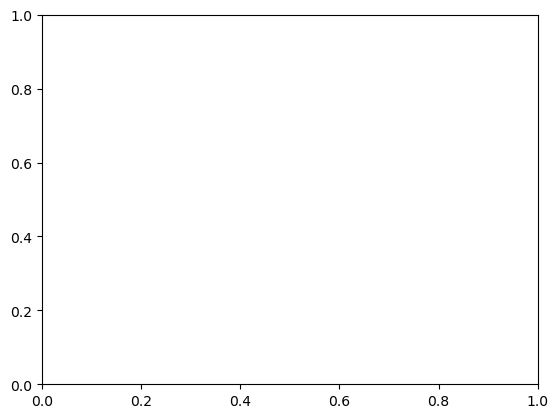

In [44]:
from matplotlib import cm, colors

fig, ax = plt.subplots()

graph0 = nx.from_pandas_edgelist(layer0_df, source="layer_0", target="layer_1")
graph1 = nx.from_pandas_edgelist(layer1_df, source="layer_1", target="layer_2")
graph2 = nx.from_pandas_edgelist(layer2_df, source="layer_2", target="layer_3")
graph3 = nx.from_pandas_edgelist(layer3_df, source="layer_3", target="layer_4" )

concatenated_graph = nx.compose_all([graph0, graph1, graph2, graph3])


In [54]:
original_number = 99000000

# Convert the number to a string
number_str = str(original_number)

last_six_digits = number_str[-6:]

last_six_digits

'000000'

In [59]:
node_labels = {n: n if str(n[:-6])=='000000' else '' for n in concatenated_graph} 
node_labels

TypeError: 'int' object is not subscriptable

AttributeError: module 'matplotlib.cm' has no attribute 'Blue'

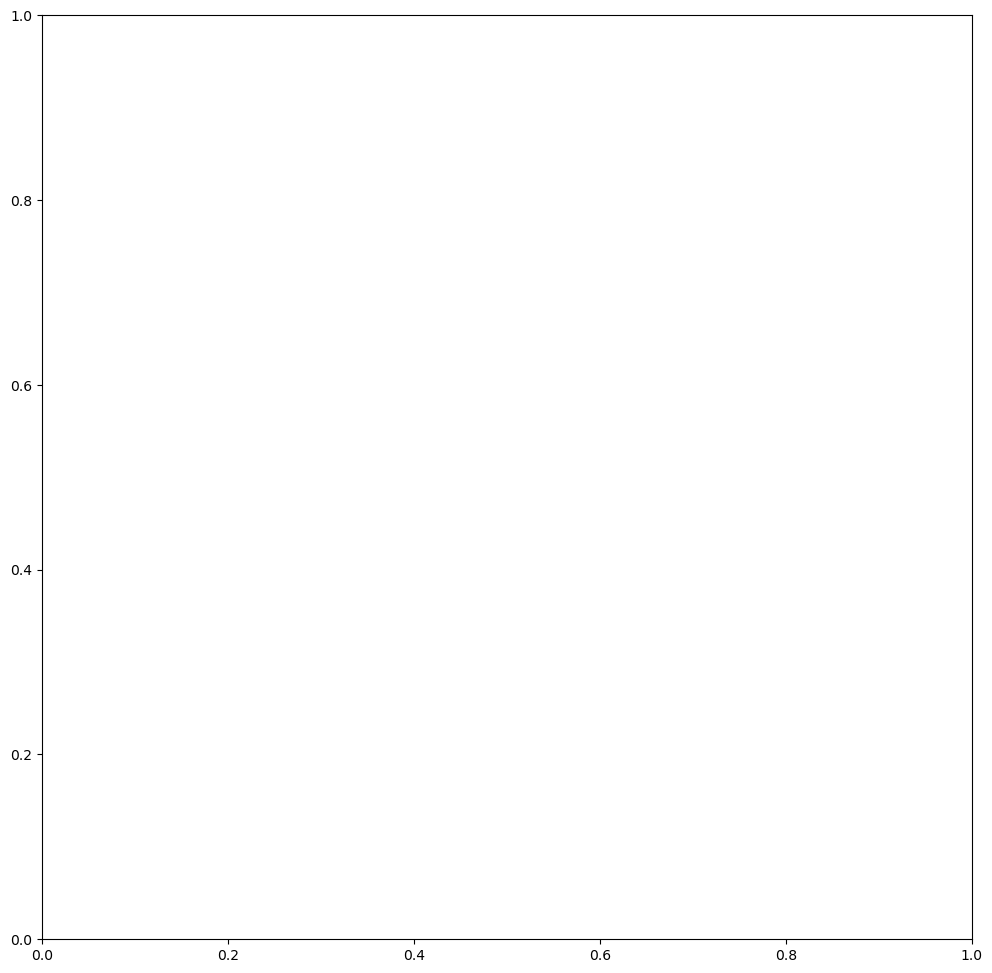

In [74]:
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import networkx as nx

# Assuming you already have the code for creating the graph

fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the size (width, height) as needed

# The rest of your code remains unchanged
graph0 = nx.from_pandas_edgelist(layer0_df, source="layer_0", target="layer_1")
graph1 = nx.from_pandas_edgelist(layer1_df, source="layer_1", target="layer_2")
graph2 = nx.from_pandas_edgelist(layer2_df, source="layer_2", target="layer_3")
graph3 = nx.from_pandas_edgelist(layer3_df, source="layer_3", target="layer_4" )

concatenated_graph = nx.compose_all([graph0, graph1, graph2, graph3])

centralities, thresh = nx.degree_centrality(concatenated_graph), .015
node_sizes = [20 if centralities[n] > thresh else 1 for n in concatenated_graph]
node_labels = {n: str(n)[:-6] if str(n)[2:]=='000000'  else '' for n in concatenated_graph} 

cmap_values = []
for node in concatenated_graph:
    if len(str(node))==2: 
        cmap_values.append(2)
    elif len(str(node))==4:
        cmap_values.append(4)
    elif len(str(node))==6:
        cmap_values.append(6)
    else: 
        cmap_values.append(8)

nx.draw(concatenated_graph, node_size=50, cmap=cm.Blue, node_color=cmap_values , labels=node_labels, pos=nx.nx_pydot.graphviz_layout(concatenated_graph, prog='circo'))

plt.show()

/tmp/ipykernel_126/2598240442.py:28: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(concatenated_graph, node_size=50, cmap=cm.Paired, node_color=cmap_values , labels=node_labels, pos=nx.nx_pydot.graphviz_layout(concatenated_graph, prog='circo'))


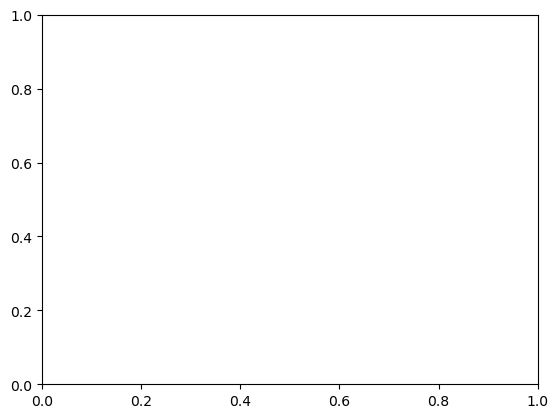

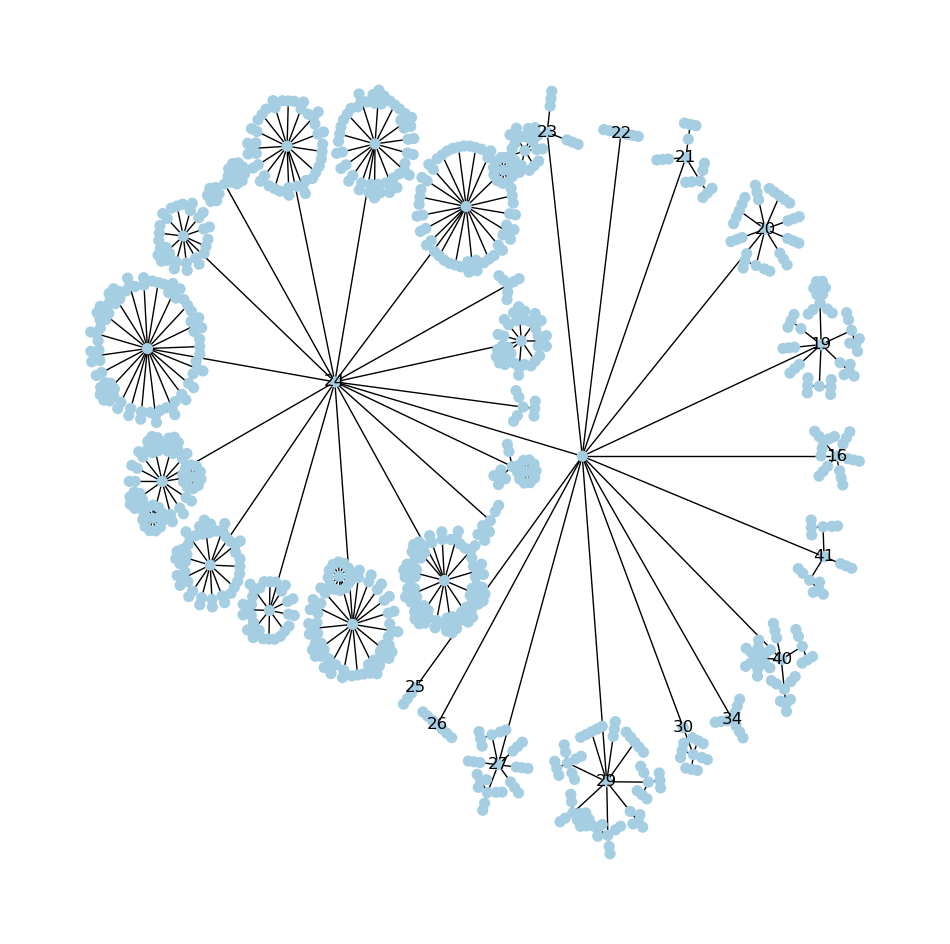

In [82]:
from matplotlib import cm, colors

fig, ax = plt.subplots()

graph0 = nx.from_pandas_edgelist(layer0_df, source="layer_0", target="layer_1")
graph1 = nx.from_pandas_edgelist(layer1_df, source="layer_1", target="layer_2")
graph2 = nx.from_pandas_edgelist(layer2_df, source="layer_2", target="layer_3")
graph3 = nx.from_pandas_edgelist(layer3_df, source="layer_3", target="layer_4" )

concatenated_graph = nx.compose_all([graph0, graph1, graph2, graph3])
fig, ax = plt.subplots(figsize=(12, 12))  

centralities, thresh = nx.degree_centrality(concatenated_graph), .015
node_sizes = [20 if centralities[n] > thresh else 1 for n in concatenated_graph]
node_labels = {n: str(n)[:-6] if str(n)[2:]=='000000' else '' for n in concatenated_graph}

cmap_values = []
for node in concatenated_graph:
    if len(str(node))==2: 
        cmap_values.append(2)
    elif len(str(node))==4:
        cmap_values.append(4)
    elif len(str(node))==6:
        cmap_values.append(6)
    else: 
        cmap_values.append(8)
        
nx.draw(concatenated_graph, node_size=50, cmap=cm.Paired, node_color=cmap_values , labels=node_labels, pos=nx.nx_pydot.graphviz_layout(concatenated_graph, prog='circo'))


In [22]:
layer0_df.columns

Index(['layer_0', 'layer_1', 'count'], dtype='object')

In [25]:
import numpy as np

In [34]:
np_lay0 = layer0_df[['layer_0', 'layer_1']].to_numpy()
np_lay1 = layer1_df[['layer_1', 'layer_2']].to_numpy()
np_lay2 = layer2_df[['layer_2', 'layer_3']].to_numpy()
np_lay3 = layer3_df[['layer_3', 'layer_4']].to_numpy()

Lay12 = np.concatenate((np_lay0, np_lay1), axis=0)
Lay23 = np.concatenate((Lay12, np_lay2), axis=0)
concat_data = np.concatenate((Lay23, np_lay3), axis=0)
concat_data = concat_data.astype(np.float64)
concat_data

array([[       0., 16000000.],
       [       0., 19000000.],
       [       0., 20000000.],
       ...,
       [41090200., 41090290.],
       [41090500., 41090501.],
       [41090500., 41090590.]])

In [35]:
# coords = np.array(list(concat_data.values()))
new_pos = nx.rescale_layout(concat_data) 
new_pos

array([[-1.        , -0.36749622],
       [-1.        , -0.24567672],
       [-1.        , -0.20507022],
       ...,
       [ 0.66852923,  0.65133266],
       [ 0.66854141,  0.65134122],
       [ 0.66854141,  0.65134484]])

NameError: name 'scalarMap' is not defined

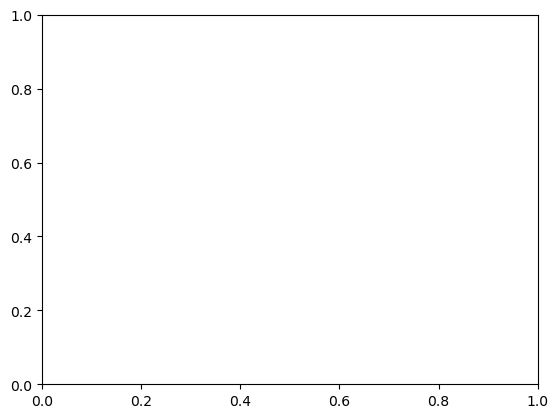

In [38]:

centralities, thresh = nx.degree_centrality(concatenated_graph), .015
node_sizes = [20 if centralities[n] > thresh else 1 for n in concatenated_graph]
node_labels = {n: n if len(str(n))==2 else '' for n in concatenated_graph} 


# coords = np.array(list(concat_data.values()))
new_pos = nx.rescale_layout(concat_data) 

cmap_values = []
for node in concatenated_graph:
    if len(str(node))==2: 
        cmap_values.append(2)
    elif len(str(node))==4:
        cmap_values.append(4)
    elif len(str(node))==6:
        cmap_values.append(6)
    else: 
        cmap_values.append(8)
        

val_map = {'kind1': 2, 
           'kind2': 2, 
           'Obsolete': 2, 
           'Initialisation': 1, 
           'Draft': 4, 
           'Release': 3} 
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in val_map:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map[label]),
            label=label)
# nx.draw(concatenated_graph, node_size=50, cmap=cm.Pastel1, node_color=cmap_values , labels=node_labels, pos=nx.circular_layout(concatenated_graph))
# nx.draw_networkx(concatenated_graph, new_pos, node_size=50, cmap=cm.Pastel1, node_color=cmap_values , labels=node_labels, pos=nx.nx_pydot.graphviz_layout(new_pos, prog='circo'))
nx.draw_networkx(concatenated_graph, node_size=50, cmap=cm.Pastel1, node_color=cmap_values , labels=node_labels, pos=nx.nx_pydot.graphviz_layout(concatenated_graph, prog='circo', ax=ax))

plt.legend()
f.tight_layout()
plt.show()

In [ ]:
fig.savefig("graph2.pdf", format="pdf")
fig.show()

C:\Users\zpakz\AppData\Local\Temp\ipykernel_14856\880250153.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


# Check category names

In [ ]:
eclass_namen = eclass_namen.rename({'eClassIdentifier': 'ECLASS_8_1'}, axis=1, inplace=False)
eclass_namen

,ECLASS_8_1,eClassGroupName_DE,eClassGroupName_EN
0,14000000,Logistik (Dienstleistung),Logistics (Service)
1,14010000,Ladungssicherung,Load securing
2,14010100,Ladungssicherung für Lkw,Load securing of truck
3,14010101,"Ladungssicherung für Lkw, Stückgut","Load securing of truck, general"
4,14010102,"Ladungssicherung für Lkw, Schüttgut","Load securing of truck, bulk"
...,...,...,...
39080,42099090,"Dedizierter Probenbehälter (IVD, Sonstige, nic...","Dedicated sample container (IVD, other, unspec..."
39081,90000000,Interimsklasse (nicht spezifiziert),Interim class (unspecified)
39082,90900000,Interimsklassifikation (nicht spezifiziert),Interim classification (unspecified)
39083,90909000,Interimsklassifikation (nicht spezifiziert),Interim classification (unspecified)


In [ ]:
sorted_df.shape

(231630, 2)

In [ ]:
categories = pd.merge(sorted_df, eclass_namen, on='ECLASS_8_1', how='left')
categories 

,Konzernartikelnummer,ECLASS_8_1,eClassGroupName_DE,eClassGroupName_EN
0,3000034216,14029090,"Transport (Sonstige, nicht spezifiziert)","Transport (other, unspecified)"
1,3000541045,14029090,"Transport (Sonstige, nicht spezifiziert)","Transport (other, unspecified)"
2,3000072878,14029090,"Transport (Sonstige, nicht spezifiziert)","Transport (other, unspecified)"
3,3000482177,14029090,"Transport (Sonstige, nicht spezifiziert)","Transport (other, unspecified)"
4,1000391083,14029090,"Transport (Sonstige, nicht spezifiziert)","Transport (other, unspecified)"
...,...,...,...,...
231625,1000539148,42021690,"Schnelltest (Immunchemie, nicht spezifiziert)","Rapid test (immunochemistry, unspecified)"
231626,3000536359,42021690,"Schnelltest (Immunchemie, nicht spezifiziert)","Rapid test (immunochemistry, unspecified)"
231627,1000387278,90909090,Interimsklassifikation (nicht spezifiziert),Interim classification (unspecified)
231628,1000427664,90909090,Interimsklassifikation (nicht spezifiziert),Interim classification (unspecified)


In [12]:
# add the layer names via the "eClass8.1_Namen" dataset to each of the dumps(datasets)
def add_layer_names(data): 
    namen_Lx = eclass_namen.rename({'eClassIdentifier': 'layer_0'}, axis=1, inplace=False)
    summed_leaves = preprocess_data(data)

    for i in range(1, 5):
        # rename the names df's name column from previous round to the next one, so it can have and identical name for merging with the dump
        namen_Lx = namen_Lx.rename({'layer_'+str(i-1): 'layer_'+str(i)}, axis=1, inplace=False)
        # merge the datasets
        dump_x = pd.merge(summed_leaves, namen_Lx, on='layer_'+str(i), how='left')
        # extract the layer's specific names into a columns
        summed_leaves['group_name_layer_'+str(i)] = dump_x['eClassGroupName_EN']

    eclass_namen.rename({'layer_4': 'eClassIdentifier'}, axis=1, inplace=True)
    return summed_leaves

# for each dump 

# dump_6_named = add_layer_names(data_6)
# dump_7_named = add_layer_names(data_7)
# dump_8_named = add_layer_names(data_8)
# dump_9_named = add_layer_names(data_9)

def merge_data_with_named_form(data, named_data):
    named_data = named_data.drop(['Konzernartikelnummer', 'class_count'], axis=1)
    named_data['ECLASS_8_1'] = named_data['ECLASS_8_1'].astype('int64') 
    merged = pd.merge(data, named_data, on='ECLASS_8_1', how='left')
    return merged


# merged_6 = merge_data_with_named_form(data_6, dump_6_named)
# merged_7 = merge_data_with_named_form(data_7, dump_7_named)
# merged_8 = merge_data_with_named_form(data_8, dump_8_named)
# merged_9 = merge_data_with_named_form(data_9, dump_9_named)

# merged_6.to_excel("data/PBS/2023-05-31/data_6.xlsx")
# merged_7.to_excel("data/PBS/2023-06-06/data_7.xlsx")
# merged_8.to_excel("data/PBS/2023-07-17/data_8.xlsx")
# merged_9.to_excel("data/PBS/2023-08-16/data_9.xlsx")

In [45]:
# data_6.head(1)
data_6.shape

(231630, 10)

In [ ]:
df_diff_676.loc[:, 'count_1'] = 1
dump6_L1 = df_diff_676.groupby(by = ['layer_1']).sum()
dump6_L1.reset_index(inplace=True)
dump6_L1.sort_values(by='count_1', ascending=False, inplace=True)
# dump6_L1 = dump6_L1[['layer_1', 'ECLASS_8_1', 'Konzernartikelnummer', 'eClassGroupName_EN', 'count_1']]
dump6_L1 = dump6_L1[['layer_1', 'count_1']]

dump6_L1

,layer_1,count_1
7,24,16767
2,19,2452
13,40,1976
10,29,1860
14,41,908
11,30,483
1,16,452
3,20,386
9,27,362
6,23,284


### naming the layers of data dump from may 24th

In [13]:
dump_may_named = add_layer_names(data)
merged = merge_data_with_named_form(data, dump_may_named)
merged.head(2)

<class 'str'>


/tmp/ipykernel_126/1930461088.py:13: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  summed_leaves = copied_sorted_df.groupby(by='ECLASS_8_1').agg(sum)


,Konzernartikelnummer,ECLASS_8_1,ECLASS_Name,Bezeichnung,Webbezeichnung,Detailinformation,LieferantenDetailinformation,OEMNummer,Hersteller,Marke,layer_1,layer_2,layer_3,layer_4,group_name_layer_1,group_name_layer_2,group_name_layer_3,group_name_layer_4
0,2766168000,24292401,Standardkarteikarte,Karteikarte zu 20Bl. A4 SIGEL LP701,Karteikarte zu 20 Stück A4 SIGEL LP701,"160 Karten A7 blanko weiß,zum Selbergestalten ...",PC- Karten weiß zum beidseitigen Bedrucken mit...,LP701,SIGEL GMBH,SIGEL,24000000,24290000,24292400,24292401,"Office product, facility and technic, papeterie","Filing system, storage system",File card,File card (default)
1,1000255650,24360202,Konferenzmappe,Schreibmappe A4 blau LEITZ 4580-00-37 Bebop,Schreibmappe A4 blau Bebop LEITZ 4580-00-37,"m. Schreibblock u. Ablagefächern, 4 Sichthülle...","Leitz Schreibmappe Bebop, mit liniertem Schrei...",4580-00-37,Esselte Office Products GmbH,LEITZ,24000000,24360000,24360200,24360202,"Office product, facility and technic, papeterie","Bag, case",Bag,Conference portfolio


In [14]:
merged['count_1'] = 1
dump1_L1 = merged.groupby(by = ['layer_1']).sum()
dump1_L1.reset_index(inplace=True)
dump1_L1.sort_values(by='count_1', ascending=False, inplace=True)
dump1_L1 = dump1_L1[['layer_1', 'count_1']]

merged_dump_67_l1 = pd.merge(dump1_L1, merged[['layer_1', 'group_name_layer_1']], on="layer_1", how="left")
merged_dump_67_l1 = merged_dump_67_l1.drop_duplicates(subset=['layer_1']).reset_index().drop('index', axis=1)
merged_dump_67_l1

,layer_1,count_1,group_name_layer_1
0,24000000,181314,"Office product, facility and technic, papeterie"
1,19000000,16813,"Information, communication and media technology"
2,29000000,12954,"Home economics, Home technology"
3,40000000,3100,"Occupational safety, accident prevention"
4,23000000,2796,"Machine element, fixing, mounting"
5,16000000,1917,"Food, beverage, tobacco"
6,20000000,1876,Packing material
7,27000000,1661,"Electric engineering, automation, process cont..."
8,41000000,1609,Marketing
9,21000000,1298,"Manufacturing facility, workshop equipment, tool"


In [18]:
merged_dump_67_l1.iloc[14].group_name_layer_1    

'Energy, extraction product, secondary raw material and residue'

In [36]:
merged[['layer_1', 'group_name_layer_1']].drop_duplicates().reset_index().drop('index', axis=1)

,layer_1,group_name_layer_1
0,24000000,"Office product, facility and technic, papeterie"
1,19000000,"Information, communication and media technology"
2,23000000,"Machine element, fixing, mounting"
3,29000000,"Home economics, Home technology"
4,16000000,"Food, beverage, tobacco"
5,40000000,"Occupational safety, accident prevention"
6,30000000,"Auxiliary supply, additive, cleaning agent"
7,21000000,"Manufacturing facility, workshop equipment, tool"
8,35000000,"Semifinished product, material"
9,34000000,"Medicine, medical technology"


Extracting data samples for the thesis


In [29]:
print(eclass_namen.loc[eclass_namen.eClassIdentifier.apply(lambda x: divmod(x, 1000000)[0] == 24)].loc[11020].eClassGroupName_DE)
print(eclass_namen.loc[eclass_namen.eClassIdentifier.apply(lambda x: divmod(x, 1000000)[0] == 24)].loc[11021].eClassGroupName_EN)
print(eclass_namen.loc[eclass_namen.eClassIdentifier.apply(lambda x: divmod(x, 1000000)[0] == 24)].loc[11022].eClassGroupName_EN)
print(eclass_namen.loc[eclass_namen.eClassIdentifier.apply(lambda x: divmod(x, 1000000)[0] == 24)].loc[11023].eClassGroupName_EN)

Büromaterial, Büroeinrichtung, Bürotechnik, Papeterie
Data processing equipment (non-technical)
Data media storage
CD storage, DVD storage


In [24]:

eclass_namen.loc[eclass_namen.eClassIdentifier.apply(lambda x: divmod(x, 1000000)[0] == 24)]


,eClassIdentifier,eClassGroupName_DE,eClassGroupName_EN
11020,24000000,"Büromaterial, Büroeinrichtung, Bürotechnik, Pa...","Office product, facility and technic, papeterie"
11021,24210000,EDV-Ausstattung (nicht technisch),Data processing equipment (non-technical)
11022,24210200,Datenträger-Aufbewahrung,Data media storage
11023,24210201,"CD-, DVD-Aufbewahrung","CD storage, DVD storage"
11024,24210202,MD-Aufbewahrung,MD storage
...,...,...,...
12825,24389201,Installationsrahmen (Tresor),Installation frame (safety deposit box)
12826,24389202,Alarmsystem (Tresor),Alarm system (safety deposit box)
12827,24389203,Geldsicherungssystem,Money safety system
12828,24389204,Schloss (Tresor),Lock (safety deposit box)
